The ARIMA process is like the ARMA process except it uses the differenced series, denoted as $y_t'$:

$$
y_t' = C + \phi_1 y_{t-1}' + \cdots + \phi_p y_{t-p}' + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q} + \epsilon_t
$$

In [2]:
import pandas as pd

df = pd.read_csv('data/jj.csv')

df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


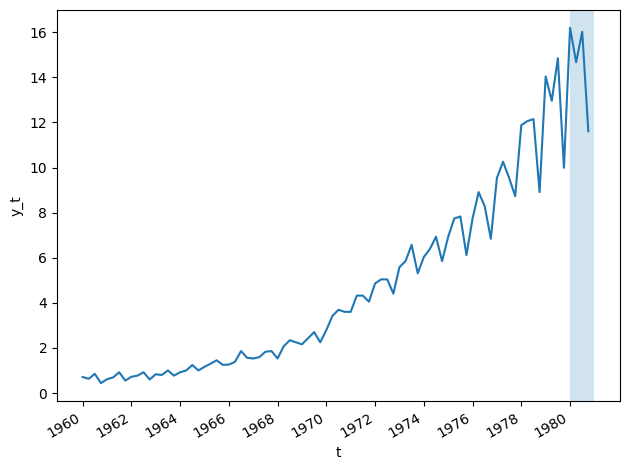

In [3]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from datetime import datetime

fig, ax = plt.subplots()
ax: Axes

ax.plot(df['data'])
ax.set_xlabel('t')
ax.set_ylabel('y_t')

ticks = df.index[::8]
labels = [datetime.strptime(d, '%Y-%m-%d').year
          for d in df['date'][::8]]
ax.set_xticks(ticks, labels)

ax.axvspan(ticks[-1], len(df), alpha=.2)

fig.autofmt_xdate()
fig.tight_layout()

In [4]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(df['data'])
print(f'ADF Statistic w/ n=0: {ad_fuller_result[0]:.3f}')
print(f'p-value w/ n=0: {ad_fuller_result[1]:.3f}')

ADF Statistic w/ n=0: 2.742
p-value w/ n=0: 1.000


In [5]:
import numpy as np

eps_diff = np.diff(df['data'], n=2)

ad_fuller_result = adfuller(eps_diff)
print(f'ADF Statistic w/ n=2: {ad_fuller_result[0]:.3f}')
print(f'p-value w/ n=2: {ad_fuller_result[1]:.3f}')

ADF Statistic w/ n=2: -3.585
p-value w/ n=2: 0.006


In [90]:
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

def optimize_ARIMA(
    endog: Union[pd.Series, list],
    order_list: list[tuple[int, int]], 
    d: int
) -> pd.DataFrame:
    results = []
    for order in tqdm(order_list):
        p, q = order
        model = (SARIMAX(endog, order=(p, d, q),
                        simple_differencing=False)
                 .fit(disp=False))
        aic: np.ndarray = model.aic
        results.append((order, aic))
    result_df = pd.DataFrame(results, columns=('(p,q)', 'AIC'))
    result_df = (result_df
                 .sort_values(by='AIC', ascending=True)
                 .reset_index(drop=True))
    return result_df

ps = range(0, 4)
qs = range(0, 4)
d = 2

order_list = list(product(ps, qs))

TRAIN_TEST_SPLIT = len(df)-4
train = df.data.iloc[:TRAIN_TEST_SPLIT]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA

,"(p,q)",AIC
0,"(3, 3)",115.269123
1,"(3, 1)",115.624981
2,"(3, 2)",115.672007
3,"(3, 0)",154.430621
4,"(0, 3)",194.654716
5,"(0, 2)",209.274484
6,"(2, 3)",220.666934
7,"(1, 3)",228.267727
8,"(1, 2)",228.935773
9,"(2, 2)",229.974693


c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


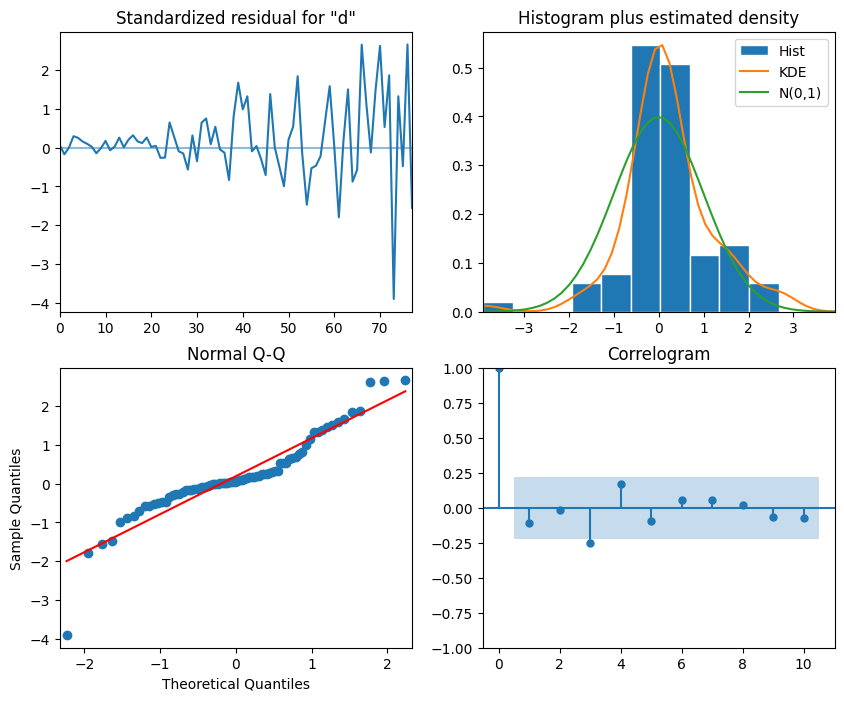

In [91]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit: SARIMAXResults = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8));

In [92]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid
lb_df = acorr_ljungbox(residuals, np.arange(1, 11))

print(lb_df)
print('smallest pvalue', lb_df['lb_pvalue'].min())

      lb_stat  lb_pvalue
1    1.661077   0.197458
2    1.665219   0.434913
3    7.202265   0.065723
4    9.172264   0.056935
5    9.796040   0.081225
6   10.035397   0.123169
7   10.289388   0.172759
8   10.321444   0.243186
9   10.667126   0.299217
10  11.103162   0.349537
smallest pvalue 0.05693499657831462


In [94]:
test = df.iloc[TRAIN_TEST_SPLIT:]
test = test.assign(naive_seasonal=df['data'].values[TRAIN_TEST_SPLIT-4:TRAIN_TEST_SPLIT])
test

,date,data,pred_mean,naive_seasonal
80,1980-01-01,16.20,9.677269,14.04
81,1980-04-01,14.67,8.615137,12.96
82,1980-07-02,16.02,7.5002,14.85
83,1980-10-01,11.61,6.332457,9.99


In [117]:
from statsmodels.tsa.statespace.mlemodel import PredictionResults

START = len(train)
END = len(df)-1
ARIMA_pred: PredictionResults = model_fit.get_prediction(START, END)
ARIMA_pred_mean = ARIMA_pred.predicted_mean
test = test.assign(ARIMA_pred_mean=ARIMA_pred_mean)

ARIMA_pred_mean

80    15.851247
81    14.380048
82    16.367977
83    11.677127
Name: predicted_mean, dtype: float64

In [88]:
from typing import Literal

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, 
                     window: int, method: Literal['mean', 'last']):
    if method == 'mean':
        pred_mean = np.empty(horizon)
        for i in range(0, horizon, window):
            mean = np.mean(df[:train_len+i].values)
            pred_mean[i:i+window] = mean
        return pred_mean
    elif method == 'last':
        pred_last = np.empty(horizon)
        for i in range(0, horizon, window):
            last = df[:train_len+i].values[-1]
            pred_last[i:i+window] = last
        return pred_last
    
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

df_diff = pd.DataFrame({'eps_diff': eps_diff})
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
df_diff['pred_mean'] = pd.Series(); df_diff['pred_last'] = pd.Series()
df_diff['pred_mean'][TRAIN_TEST_SPLIT:] = pred_mean[:-2]
df_diff['pred_last'][TRAIN_TEST_SPLIT:] = pred_last[:-2]
# df_diff.tail(10)

C:\Users\Ben\AppData\Local\Temp\ipykernel_24852\3520223071.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['pred_mean'][TRAIN_TEST_SPLIT:] = pred_mean[:-2]
C:\Users\Ben\AppData\Local\Temp\ipykernel_24852\3520223071.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['pred_last'][TRAIN_TEST_SPLIT:] = pred_last[:-2]


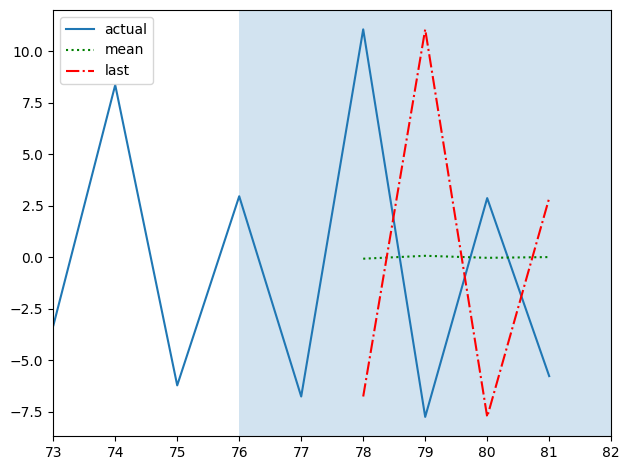

In [89]:
fig, ax = plt.subplots()
ax: Axes

ax.plot(df_diff['eps_diff'], label='actual')
ax.plot(df_diff['pred_mean'], 'g:', label='mean')
ax.plot(df_diff['pred_last'], 'r-.', label='last')

ax.legend(loc=2)

ax.set_xlim(TRAIN_TEST_SPLIT-2-3, len(df_diff))
ax.axvspan(TRAIN_TEST_SPLIT-2, len(df_diff), alpha=.2)

fig.tight_layout()

$$
\begin{align}
y_2'' = y_2' - y_1' = (y_2 - y_1) - (y_1 - y_0) &\implies y_2 = y_2'' + 2y_1 - y_0 = y_2'' \\
y_3'' = y_3' - y_2' = (y_3 - y_2) - (y_2 - y_1) &\implies y_3 = y_3'' + 2y_2 - y_1 = y_3'' + 2 y_2'' + 3 y_1 - 2 y_0 \\
y_4'' = y_4' - y_3' = (y_4 - y_3) - (y_3 - y_2) \\
&\implies y_4 = y_4'' + 2y_3 - y_2 = y_4'' + 2 (y_3'' + 2 y_2'' + 3 y_1 - 2 y_0) - (y_2'' + 2y_1 - y_0 = y_2'') \\
&\vdots \\
&\implies y_n = \sum_{i=2}^{n} (n-i+1) y_i'' + n y_1 + (n-1) y_0
\end{align}
$$

In [1]:
def inverse_diff2(diff2: np.ndarray, y0y1: np.ndarray):
    TEST_LEN = len(diff2)+2
    test = np.empty(TEST_LEN)
    test[:2] = y0y1
    y_0, y_1 = y0y1
    for n in range(2, TEST_LEN):
        val = n * y_1 - (n - 1) * y_0
        for i in range(2, n+1):
            val += (n - i + 1) * diff2[i-2]
        test[n] = val
    return test

print(inverse_diff2(df_diff['eps_diff'].iloc[TRAIN_TEST_SPLIT-2:].values,
              df['data'].iloc[TRAIN_TEST_SPLIT-2:TRAIN_TEST_SPLIT].values))
print(df['data'].iloc[TRAIN_TEST_SPLIT-2:])

NameError: name 'np' is not defined

In [118]:
df['pred_mean'] = pd.Series()
df['pred_mean'][TRAIN_TEST_SPLIT:] = inverse_diff2(
    df_diff['pred_mean'].iloc[TRAIN_TEST_SPLIT-2:].values,
    df['data'].iloc[TRAIN_TEST_SPLIT-2:TRAIN_TEST_SPLIT].values)[2:]

df['naive_seasonal'] = pd.Series()
df['naive_seasonal'][TRAIN_TEST_SPLIT:] = df['data'].iloc[TRAIN_TEST_SPLIT-len(test):TRAIN_TEST_SPLIT]

df['ARIMA_pred'] = pd.Series()
df['ARIMA_pred'][TRAIN_TEST_SPLIT:] = ARIMA_pred_mean

C:\Users\Ben\AppData\Local\Temp\ipykernel_24852\172225678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_mean'][TRAIN_TEST_SPLIT:] = inverse_diff2(
C:\Users\Ben\AppData\Local\Temp\ipykernel_24852\172225678.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['naive_seasonal'][TRAIN_TEST_SPLIT:] = df['data'].iloc[TRAIN_TEST_SPLIT-len(test):TRAIN_TEST_SPLIT]
C:\Users\Ben\AppData\Local\Temp\ipykernel_24852\172225678.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

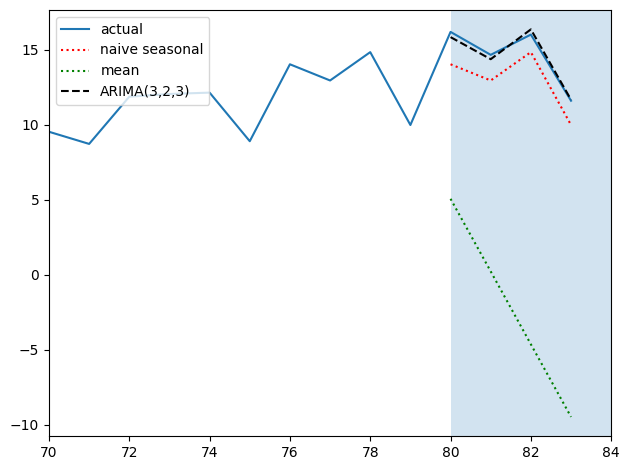

In [119]:
fig, ax = plt.subplots()
ax: Axes

ax.plot(df['data'], label='actual')
ax.plot(df['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(df['pred_mean'], 'g:', label='mean')
ax.plot(df['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlim(TRAIN_TEST_SPLIT-10, len(df))
ax.axvspan(TRAIN_TEST_SPLIT, len(df), alpha=.2)
ax.legend(loc=2)

plt.tight_layout()

In [128]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error
test = df.iloc[TRAIN_TEST_SPLIT:]
print(f"{mape(test['data'], test['naive_seasonal']):.4f}")
print(f"{mape(test['data'], test['ARIMA_pred']):.4f}")

0.1156
0.0172
